In [22]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import PIL
import PIL.Image
import matplotlib.pyplot as plt
import glob

In [23]:
train_filepath = 'datasets/cropped_lisa_1/train_1'
test_filepath = 'datasets/cropped_lisa_1/val_1'
go = glob.glob(train_filepath + '/go/*.jpg')
PIL.Image.open(go[325])

In [24]:
# Import data and create Keras dataset
batch_size = 32
img_height = 64
img_width = 64
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_filepath,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)
val_ds = tf.keras.utils.image_dataset_from_directory(
    train_filepath,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_filepath,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 28690 files belonging to 3 classes.
Using 22952 files for training.
Found 28690 files belonging to 3 classes.
Using 5738 files for validation.
Found 3257 files belonging to 3 classes.


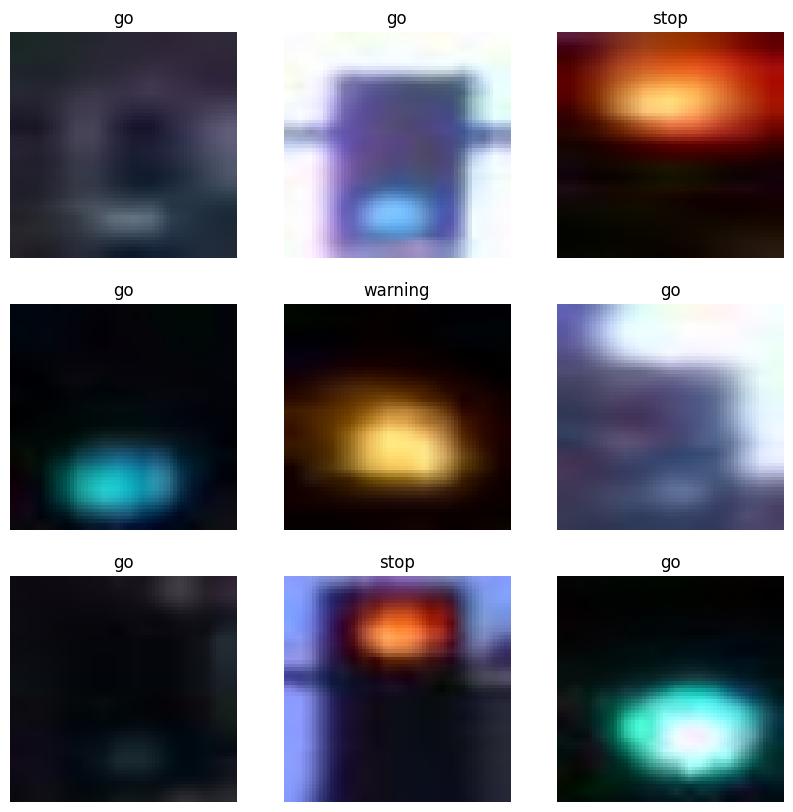

In [25]:
# Visualize data
class_names = train_ds.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

Standardizing data and tuning for performance

In [26]:
# Data standardization
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 0.99993974


In [27]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Creating the first model
This model will be a normal multi-layer perceptron with 3 hidden layers and a softmax output layer.
This will be used as a baseline for the other models.

In [28]:
num_classes = 3

model_1 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(img_height, img_width, 3)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(num_classes)
])

model_1.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [ ]:
# Train the model
epochs = 10
history = model_1.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

model_1.summary()

In [31]:
# Test the model
loss, accuracy = model_1.evaluate(test_ds)
print("Accuracy", accuracy)

102/102 [==============================] - 3s 29ms/step - loss: 0.1695 - accuracy: 0.8812
Accuracy 0.8811789751052856


Creating the second model
This model will be a convolutional neural network with 3 convolutional layers and a softmax output layer.